In [58]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
main_path=os.getcwd()
print(main_path)

C:\Users\METE\Desktop\cekcoz_v3\workspace\training_demo


In [59]:
image_path = []
for image_name in os.listdir("C:\\Users\\METE\\Desktop\\single_image_trial"):
    image_path.append(os.path.join("C:\\Users\\METE\\Desktop\\single_image_trial", image_name))
image_path = image_path[0]
print(image_path)

C:\Users\METE\Desktop\single_image_trial\deneme_1.png


In [3]:
def detect_fn(image, detection_model):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.utils import label_map_util
import numpy as np
from PIL import Image
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt


image_np = np.array(Image.open(image_path))

user_path = os.path.expanduser("~")
training_demo_path = os.path.join(user_path, "Desktop", "cekcoz_v3", "workspace", "training_demo")
config_path = os.path.join(training_demo_path, "models", "cekcoz_resnet", "pipeline.config")
configs = config_util.get_configs_from_pipeline_file(config_path)
model_config = configs["model"]
detection_model = model_builder.build(model_config=model_config, is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
checkpoint_path = os.path.join(training_demo_path, "models", "cekcoz_resnet")
ckpt.restore(os.path.join(checkpoint_path, 'ckpt-98')).expect_partial()


label_path = os.path.join(training_demo_path, "annotations", "label_map.pbtxt")
category_index = label_map_util.create_category_index_from_labelmap(label_path,use_display_name=True)


img_height, img_width = image_np.shape[0], image_np.shape[1]

# cv.imshow("image",image)
# cv.waitKey()

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor, detection_model)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.3,
    agnostic_mode=False)
plt.imshow(image_np_with_detections)
plt.show()

In [5]:
def process_data(box, detection_class, score):
    return list([box[0], box[1], box[2], box[3], detection_class + label_id_offset, score])

aggregated_list = list(map(process_data, detections['detection_boxes'], detections['detection_classes'],
                      detections['detection_scores']))

score_threshold = 0.5
applicable_list = []
for whole_values in aggregated_list:
    dummy_list = []
    if whole_values[5] > score_threshold:
        label_name = (category_index.get(int(whole_values[4]))).get("name")
        ymin = int(whole_values[0] * img_height)
        xmin = int(whole_values[1] * img_width)
        ymax = int(whole_values[2] * img_height)
        xmax = int(whole_values[3] * img_width)
        dummy_list.append(ymin)
        dummy_list.append(xmin)
        dummy_list.append(ymax)
        dummy_list.append(xmax)
        dummy_list.append(label_name)
        applicable_list.append(dummy_list)
def area(bbox):
    """Calculate area of a bounding box."""
    ymin, xmin, ymax, xmax, _ = bbox
    return (ymax - ymin) * (xmax - xmin)

def overlap_area(bbox1, bbox2):
    """Calculate overlap area between two bounding boxes."""
    ymin1, xmin1, ymax1, xmax1 = bbox1[:4]
    ymin2, xmin2, ymax2, xmax2 = bbox2[:4]

    overlap_ymin = max(ymin1, ymin2)
    overlap_xmin = max(xmin1, xmin2)
    overlap_ymax = min(ymax1, ymax2)
    overlap_xmax = min(xmax1, xmax2)

    # Check if the boxes overlap at all
    if overlap_xmin < overlap_xmax and overlap_ymin < overlap_ymax:
        return area([overlap_ymin, overlap_xmin, overlap_ymax, overlap_xmax, ''])
    return 0

filtered_boxes = []
for i in range(len(applicable_list)):
    for j in range(i + 1, len(applicable_list)):
        if applicable_list[i][4] == applicable_list[j][4]:  # If the labels are the same
            overlap = overlap_area(applicable_list[i], applicable_list[j])
            if overlap >= 0.7 * area(applicable_list[i]):  # If bbox j contains 70% or more of bbox i
                break
            elif overlap >= 0.7 * area(applicable_list[j]):  # If bbox i contains 70% or more of bbox j
                continue
    else:  # If the loop didn't break, add the box to the filtered list
        filtered_boxes.append(applicable_list[i])

print(filtered_boxes)

[[102, 284, 132, 317, 'roller_support'], [22, 99, 102, 116, 'point_load'], [136, 303, 167, 369, 'spacing'], [24, 362, 101, 377, 'point_load'], [22, 230, 102, 246, 'point_load'], [137, 237, 168, 305, 'spacing'], [97, 34, 111, 49, 'pin_support'], [138, 106, 170, 236, 'spacing'], [139, 43, 170, 109, 'spacing']]


In [6]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import os
import time


def read_text_on_image(path):

    subscription_key = "d9db8bd3bed7440a86b510dca41abdc6"
    endpoint = "https://cekcozocr.cognitiveservices.azure.com/"

    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))


    read_image_path = path
    # Open the image
    read_image = open(read_image_path, "rb")

    # Call API with image and raw response (allows you to get the operation location)
    read_response = computervision_client.read_in_stream(read_image, raw=True)
    # Get the operation location (URL with ID as last appendage)
    read_operation_location = read_response.headers["Operation-Location"]
    # Take the ID off and use to get results
    operation_id = read_operation_location.split("/")[-1]

    # Call the "GET" API and wait for the retrieval of the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status.lower () not in ['notstarted', 'running']:
            break
        print ('Waiting for result...')
        time.sleep(10)


    reading_results = []
    # Print results, line by line
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                dummy_list = []
                dummy_list.append(line.text)
                dummy_list.append(line.bounding_box)
                # print(line.text)
                # print(line.bounding_box)
                reading_results.append(dummy_list)

    return reading_results

ocr_results = read_text_on_image(image_path)
print(ocr_results)


Waiting for result...
[['10 kN', [115.0, 25.0, 157.0, 24.0, 157.0, 38.0, 115.0, 38.0]], ['20 kN', [244.0, 23.0, 286.0, 22.0, 287.0, 36.0, 244.0, 37.0]], ['5 kN', [375.0, 22.0, 410.0, 22.0, 409.0, 35.0, 375.0, 35.0]], ['A', [22.0, 84.0, 33.0, 84.0, 34.0, 95.0, 23.0, 95.0]], ['B.', [86.0, 82.0, 102.0, 83.0, 103.0, 96.0, 86.0, 94.0]], ['C', [215.0, 81.0, 225.0, 81.0, 226.0, 94.0, 215.0, 94.0]], ['D', [297.0, 81.0, 307.0, 81.0, 307.0, 93.0, 297.0, 93.0]], ['E', [347.0, 79.0, 358.0, 80.0, 357.0, 93.0, 347.0, 92.0]], ['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], ['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]]]


In [7]:
# Spacing (Dimension) and Node classes defined and data prepared below this line

In [8]:
# Function to compute center of an object detection bounding box
def compute_center_obj(bbox):
    y1, x1, y2, x2 = bbox
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    return center_x, center_y

# Function to compute center of an OCR bounding box
def compute_center_ocr(bbox):
    x1, y1, x2, y2, x3, y3, x4, y4 = bbox
    center_x = (x1 + x3) / 2
    center_y = (y1 + y3) / 2
    return center_x, center_y

# Function to compute Euclidean distance between two centers
def euclidean_distance(center1, center2):
    return ((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)**0.5

# Function to compute distances between OCR results and object detection results
# and keep results with distance < 100 pixels
def filter_results_by_distance(obj_detection_bbox, ocr_results, threshold):
    filtered_results = []
    obj_center = compute_center_obj(obj_detection_bbox)
    
    for result in ocr_results:
        _, ocr_bbox = result
        ocr_center = compute_center_ocr(ocr_bbox)
        distance = euclidean_distance(obj_center, ocr_center)
        if distance < threshold:
            filtered_results.append(result)
        
    return filtered_results

def adjust_threshold(bbox):
    if bbox[3]-bbox[1] > bbox[2]-bbox[0]:
        return bbox[2]-bbox[0]+10
    else:
        return bbox[3]-bbox[1] + 10

In [9]:
def match_spacings(spacing_bbox, readings):
    final_results = []
    for bbox in spacing_bbox:
        threshold = adjust_threshold(bbox)
        filtered_ocr_results = filter_results_by_distance(bbox, readings, threshold)
        filtered_ocr_results.append(bbox)
        final_results.append(filtered_ocr_results)
    return final_results
spacing_bbox = [item[:4] for item in filtered_boxes if item[4] == 'spacing']
spacing_matching_results = match_spacings(spacing_bbox, ocr_results)
print(spacing_bbox)
print(spacing_matching_results)

[[136, 303, 167, 369], [137, 237, 168, 305], [138, 106, 170, 236], [139, 43, 170, 109]]
[[['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], [136, 303, 167, 369]], [['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]], [137, 237, 168, 305]], [['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], [139, 43, 170, 109]]]


In [10]:
for element in spacing_matching_results:
    print(element)

[['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], [136, 303, 167, 369]]
[['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]], [137, 237, 168, 305]]
[['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]]
[['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], [139, 43, 170, 109]]


In [11]:
spacing_matching_results = [item for item in spacing_matching_results if isinstance(item[0][0], str)]
print(spacing_matching_results)

[[['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], [136, 303, 167, 369]], [['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]], [137, 237, 168, 305]], [['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], [139, 43, 170, 109]]]


In [12]:
# Removing absurd characters from spacing readings

import re

pattern = r"(\d+([.]\d+)?|(\d+\s*/\s*\d+))\s*(m|meters?)"

for item in spacing_matching_results:
    reading = item[0][0]  # OCR reading is the second element in each item
    match = re.search(pattern, reading)
    if match:
        extracted_value = match.group()
        item[0][0] = extracted_value  # Update the original reading with the extracted value

print(spacing_matching_results)

[[['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], [136, 303, 167, 369]], [['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['-', [308.0, 145.0, 308.0, 158.0, 300.0, 157.0, 300.0, 145.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]], [137, 237, 168, 305]], [['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], [139, 43, 170, 109]]]


In [13]:
filtered_results = []
for group in spacing_matching_results:
    filtered_group = [element for element in group if (isinstance(element[0], str) and re.match(pattern, element[0])) or isinstance(element[0], int)]
    filtered_results.append(filtered_group)

print(filtered_results)

[[['1 m', [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], [136, 303, 167, 369]], [['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], [137, 237, 168, 305]], [['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], [139, 43, 170, 109]]]


In [14]:
def extract_value_unit(text):
    # regex pattern to match value and unit (supports meter, m, feet, ft, inch)
    match = re.match(r'(\d+)\s*(meters?|ft|feet|inch(?:es)?|m)', text, re.IGNORECASE)
    if match:
        value, unit = match.groups()
        return [value, unit]
    return [text]

reformatted_results = []
for entry in filtered_results:
    text_data, bbox_data = entry
    text, coords = text_data
    new_text_data = [extract_value_unit(text), coords]
    reformatted_results.append([new_text_data, bbox_data])

print(reformatted_results)

[[[['1', 'm'], [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], [136, 303, 167, 369]], [[['1', 'm'], [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], [137, 237, 168, 305]], [[['2', 'm'], [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [[['1', 'm'], [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], [139, 43, 170, 109]]]


In [15]:
horizontal_spacings = []
vertical_spacings = []
for element in reformatted_results:
    y1,x1,y2,x2 = element[1]
    if x2-x1 > y2-y1:
        horizontal_spacings.append(element)
    else:
        vertical_spacings.appende(element)
print(horizontal_spacings)
print(vertical_spacings)

[[[['1', 'm'], [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], [136, 303, 167, 369]], [[['1', 'm'], [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], [137, 237, 168, 305]], [[['2', 'm'], [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [[['1', 'm'], [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], [139, 43, 170, 109]]]
[]


In [16]:
sorted_horizontal_spacings = sorted(horizontal_spacings, key=lambda x: (x[1][1] + x[1][3]) / 2)

print(sorted_horizontal_spacings)
    

[[[['1', 'm'], [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], [139, 43, 170, 109]], [[['2', 'm'], [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], [138, 106, 170, 236]], [[['1', 'm'], [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], [137, 237, 168, 305]], [[['1', 'm'], [326.0, 139.0, 351.0, 139.0, 352.0, 152.0, 326.0, 151.0]], [136, 303, 167, 369]]]


In [17]:
class Dimension:
    def __init__(self, node_1=None, node_2=None, value=None, unit=None, obj_det_bbox=None, text_bbox=None):
        self.node_1 = node_1
        self.node_2 = node_2
        self.value = value
        self.unit = unit
        self.obj_det_bbox = obj_det_bbox
        self.text_bbox = text_bbox

    def __repr__(self):
        return (f"Dimension(node_1={self.node_1}, node_2={self.node_2}, value={self.value}, "
                f"unit={self.unit}, obj_det_bbox={self.obj_det_bbox}, text_bbox={self.text_bbox})")
class Node:
    def __init__(self, bbox_x=None, bbox_y=None, shape_x=None, shape_y=None, name=None):
        self.bbox_x = bbox_x
        self.bbox_y = bbox_y
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.name = name

    def __eq__(self, other):
        if isinstance(other, Node):
            return (self.bbox_x == other.bbox_x and self.bbox_y == other.bbox_y 
                    and self.shape_x == other.shape_x and self.shape_y == other.shape_y 
                    and self.name == other.name)
        return False

    def __repr__(self):
        return f"Node(name={self.name}, bbox_x={self.bbox_x}, bbox_y={self.bbox_y}, shape_x={self.shape_x}, shape_y={self.shape_y})"


In [18]:
spacing_instances = []
node_instances = []
shape_x_start = 0
for spacing_number in range(len(sorted_horizontal_spacings)):
    if spacing_number == 0:
        y1,x1,y2,x2 = sorted_horizontal_spacings[0][1]
        distance = sorted_horizontal_spacings[0][0][0][0]
        unit = sorted_horizontal_spacings[0][0][0][1]
        obj_det_bbox = sorted_horizontal_spacings[0][1]
        text_bbox = sorted_horizontal_spacings[0][0][1]
        bbox_x = x1
        bbox_y = int((y1+y2)/2)
        node_1 = Node(bbox_x,bbox_y,shape_x_start,0)
        node_instances.append(node_1)
        bbox_x = x2
        bbox_y = int((y1+y2)/2)
        node_2 = Node(bbox_x,bbox_y,shape_x_start+int(distance),0)
        node_instances.append(node_2)
        spacing = Dimension(node_1, node_2, distance, unit, obj_det_bbox, text_bbox)
        spacing_instances.append(spacing)
    else:
        spacing_data = sorted_horizontal_spacings[spacing_number]
        y1,x1,y2,x2 = sorted_horizontal_spacings[spacing_number][1]
        for node_info in node_instances:
            if np.absolute(node_info.bbox_x - x1) < 20:
                distance = sorted_horizontal_spacings[spacing_number][0][0][0]
                unit = sorted_horizontal_spacings[spacing_number][0][0][1]
                obj_det_bbox = sorted_horizontal_spacings[spacing_number][1]
                text_bbox = sorted_horizontal_spacings[spacing_number][0][1]
                bbox_x = x2
                bbox_y = int((y1+y2)/2)
                shape_x = node_info.shape_x + int(distance)
                node_2 = Node(bbox_x,bbox_y,shape_x,0)
                node_instances.append(node_2)
                spacing = Dimension(node_info, node_2, distance, unit, obj_det_bbox, text_bbox)
                spacing_instances.append(spacing)
                break
            elif np.absolute(node_info.bbox_x - x2) < 20:
                distance = sorted_horizontal_spacings[spacing_number][0][0][0]
                unit = sorted_horizontal_spacings[spacing_number][0][0][1]
                obj_det_bbox = sorted_horizontal_spacings[spacing_number][1]
                text_bbox = sorted_horizontal_spacings[spacing_number][0][1]
                bbox_x = x1
                bbox_y = int((y1+y2)/2)
                shape_x = node_info.shape_x - int(distance)
                node_1 = Node(bbox_x,bbox_y,shape_x,0)
                node_instances.append(node_1)
                spacing = Dimension(node_1, node_info, distance, unit, obj_det_bbox, text_bbox)
                spacing_instances.append(spacing)
    

print(spacing_instances)

[Dimension(node_1=Node(name=None, bbox_x=43, bbox_y=154, shape_x=0, shape_y=0), node_2=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), value=1, unit=m, obj_det_bbox=[139, 43, 170, 109], text_bbox=[61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]), Dimension(node_1=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), node_2=Node(name=None, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), value=2, unit=m, obj_det_bbox=[138, 106, 170, 236], text_bbox=[159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]), Dimension(node_1=Node(name=None, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), node_2=Node(name=None, bbox_x=305, bbox_y=152, shape_x=4, shape_y=0), value=1, unit=m, obj_det_bbox=[137, 237, 168, 305], text_bbox=[257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]), Dimension(node_1=Node(name=None, bbox_x=305, bbox_y=152, shape_x=4, shape_y=0), node_2=Node(name=None, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0), value=1, unit=m, obj_det_bbox=[136, 303, 1

In [19]:
print(node_instances)

[Node(name=None, bbox_x=43, bbox_y=154, shape_x=0, shape_y=0), Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), Node(name=None, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), Node(name=None, bbox_x=305, bbox_y=152, shape_x=4, shape_y=0), Node(name=None, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0)]


In [20]:
def calculate_distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

In [21]:
# Bound it to image resolution later if needed
distance_threshold = 100
for text, bbox in ocr_results:
    if re.match(r'^[A-Za-z]$', text):  # Check if the text is a single letter (either uppercase or lowercase)
        center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
        center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4
        
        distances = [(node, calculate_distance(center_x, center_y, node.bbox_x, node.bbox_y)) for node in node_instances]
        closest_node, min_distance = min(distances, key=lambda x: x[1])

        if min_distance <= distance_threshold:
            closest_node.name = text

print(node_instances)

[Node(name=A, bbox_x=43, bbox_y=154, shape_x=0, shape_y=0), Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), Node(name=D, bbox_x=305, bbox_y=152, shape_x=4, shape_y=0), Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0)]


In [22]:
# Support related operations (class definiton, data preparation) done below this line

In [23]:
support_bbox = [box for box in filtered_boxes if 'support' in box[-1]]
print(support_bbox)

[[102, 284, 132, 317, 'roller_support'], [97, 34, 111, 49, 'pin_support']]


In [24]:
class FixSupport:
    def __init__(self, node=None):
        self.node = node

    def __repr__(self):
        return f"FixSupport(node={self.node})"

In [25]:
class PinSupport:
    pass

In [26]:
class RollerSupport:
    pass

In [27]:
fix_support_instances = []

for bbox in support_bbox:
    if bbox[-1] == 'fix_support':
        center_x = (bbox[1] + bbox[3]) / 2
        center_y = (bbox[0] + bbox[2]) / 2
        
        closest_node = min(node_instances, key=lambda node: calculate_distance(center_x, center_y, node.bbox_x, node.bbox_y))
        
        fix_support_instances.append(FixSupport(node=closest_node))

print(fix_support_instances)

[]


In [28]:
# Frame related operations done below

In [29]:
class Frame:
    def __init__(self, *nodes):
        if len(nodes) < 2:
            raise ValueError("A Frame requires at least two nodes.")
        self.nodes = nodes

    def add_node(self, node):
        self.nodes = (*self.nodes, node)

    def contains(self, node):
        x_vals = [n.shape_x for n in self.nodes]
        y_vals = [n.shape_y for n in self.nodes]
        
        return min(x_vals) <= node.shape_x <= max(x_vals) and min(y_vals) <= node.shape_y <= max(y_vals)

    def __repr__(self):
        nodes_representation = ', '.join([repr(node) for node in self.nodes])
        return f"Frame(nodes=({nodes_representation}))"

In [30]:
frame_boxes = [box for box in filtered_boxes if box[-1] == 'frame']

print(frame_boxes)

[]


In [31]:
def calculate_distance_x(x1, x2):
    return abs(x2 - x1)

frame_instances = []

for box in frame_boxes:
    x1 = box[1]
    x2 = box[3]

    # Get the closest node to x1 and x2
    closest_node_1 = min(node_instances, key=lambda node: calculate_distance_x(x1, node.bbox_x))
    closest_node_2 = min(node_instances, key=lambda node: calculate_distance_x(x2, node.bbox_x))

    frame_instance = Frame(closest_node_1, closest_node_2)
    frame_instances.append(frame_instance)
    
for frame in frame_instances:
    for node in node_instances:
        if frame.contains(node) and node not in frame.nodes:
            frame.add_node(node)

print(frame_instances)

[]


In [32]:
# Point load related operations done below

In [33]:
class PointLoad:
    def __init__(self, node=None, direction="+", value=None, unit=None):
        self.node = node
        self.direction = direction
        self.value = value
        self.unit = unit

    def __repr__(self):
        return f"PointLoad(node={self.node}, direction={self.direction}, value={self.value}, unit={self.unit})"

In [34]:
pl_boxes = [box for box in filtered_boxes if box[-1] == 'point_load']
print(pl_boxes)

[[22, 99, 102, 116, 'point_load'], [24, 362, 101, 377, 'point_load'], [22, 230, 102, 246, 'point_load']]


In [35]:
def calculate_distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


In [36]:
point_load_instances = []

for box in pl_boxes:
    center_x = (box[1] + box[3]) / 2
    center_y = (box[0] + box[2]) / 2
    
    closest_node = min(node_instances, key=lambda node: calculate_distance(center_x, center_y, node.bbox_x, node.bbox_y))

    # For simplicity, I'm not assigning direction, value, and unit. 
    # These can be assigned based on further criteria or user input.
    pl_instance = PointLoad(node=closest_node)
    point_load_instances.append(pl_instance)

print(point_load_instances)

[PointLoad(node=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), direction=+, value=None, unit=None), PointLoad(node=Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0), direction=+, value=None, unit=None), PointLoad(node=Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), direction=+, value=None, unit=None)]


In [37]:
def calculate_distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

texts_within_range = []

for pl_box in pl_boxes:
    pl_center_x = (pl_box[1] + pl_box[3]) / 2
    pl_center_y = (pl_box[0] + pl_box[2]) / 2

    for text_entry in ocr_results:
        text, bbox = text_entry[0], text_entry[1]
        center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
        center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4
        
        if calculate_distance(pl_center_x, pl_center_y, center_x, center_y) <= 200:
            texts_within_range.append(text_entry)

print(texts_within_range)


[['10 kN', [115.0, 25.0, 157.0, 24.0, 157.0, 38.0, 115.0, 38.0]], ['20 kN', [244.0, 23.0, 286.0, 22.0, 287.0, 36.0, 244.0, 37.0]], ['A', [22.0, 84.0, 33.0, 84.0, 34.0, 95.0, 23.0, 95.0]], ['B.', [86.0, 82.0, 102.0, 83.0, 103.0, 96.0, 86.0, 94.0]], ['C', [215.0, 81.0, 225.0, 81.0, 226.0, 94.0, 215.0, 94.0]], ['D', [297.0, 81.0, 307.0, 81.0, 307.0, 93.0, 297.0, 93.0]], ['1 m', [61.0, 141.0, 88.0, 142.0, 88.0, 153.0, 61.0, 153.0]], ['2 m', [159.0, 139.0, 186.0, 140.0, 186.0, 153.0, 158.0, 152.0]], ['1 m', [257.0, 139.0, 284.0, 140.0, 284.0, 151.0, 256.0, 152.0]], ['-', [112.0, 146.0, 112.0, 158.0, 103.0, 158.0, 103.0, 146.0]], ['X', [245.0, 158.0, 237.0, 172.0, 225.0, 162.0, 233.0, 148.0]], ['20 kN', [244.0, 23.0, 286.0, 22.0, 287.0, 36.0, 244.0, 37.0]], ['5 kN', [375.0, 22.0, 410.0, 22.0, 409.0, 35.0, 375.0, 35.0]], ['C', [215.0, 81.0, 225.0, 81.0, 226.0, 94.0, 215.0, 94.0]], ['D', [297.0, 81.0, 307.0, 81.0, 307.0, 93.0, 297.0, 93.0]], ['E', [347.0, 79.0, 358.0, 80.0, 357.0, 93.0, 347.0,

In [38]:
pattern = r"(?:[A-Za-z]*\s*=\s*)?(?P<value>\d+)\s*(?P<unit>kN)"

for text_entry in texts_within_range:
    text = text_entry[0]
    bbox = text_entry[1]
    center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
    center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4
    
    match = re.search(pattern, text)
    if match:
        value = match.group("value")
        unit = match.group("unit")

        # Find the closest PointLoad instance
        closest_pl = min(point_load_instances, key=lambda pl: calculate_distance(center_x, center_y, pl.node.bbox_x, pl.node.bbox_y))

        # Assign the value and unit to the closest PointLoad instance
        closest_pl.value = value
        closest_pl.unit = unit
        print(closest_pl)

PointLoad(node=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), direction=+, value=10, unit=kN)
PointLoad(node=Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), direction=+, value=20, unit=kN)
PointLoad(node=Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), direction=+, value=20, unit=kN)
PointLoad(node=Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0), direction=+, value=5, unit=kN)
PointLoad(node=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), direction=+, value=10, unit=kN)
PointLoad(node=Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), direction=+, value=20, unit=kN)
PointLoad(node=Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0), direction=+, value=5, unit=kN)


In [39]:
# Pipeline till this point is working fine, below is the image recreating phase

In [40]:
sorted_nodes = sorted(node_instances, key=lambda node: (node.shape_y, node.shape_x))

print(sorted_nodes)

[Node(name=A, bbox_x=43, bbox_y=154, shape_x=0, shape_y=0), Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), Node(name=D, bbox_x=305, bbox_y=152, shape_x=4, shape_y=0), Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0)]


In [41]:
connected_elements = []
for node in sorted_nodes:
    dummy_list = []
    # Check frames
    for frame in frame_instances:
        if node in frame.nodes:
            dummy_list.append(frame)
    
    # Check fix_supports
    for fix_support in fix_support_instances:
        if fix_support.node == node:
            dummy_list.append(fix_support)

    # Check point_loads
    for point_load in point_load_instances:
        if point_load.node == node:
            dummy_list.append(point_load)
    connected_elements.append(dummy_list)
for element in connected_elements:
    print(element)
    print("---------")

[]
---------
[PointLoad(node=Node(name=None, bbox_x=109, bbox_y=154, shape_x=1, shape_y=0), direction=+, value=10, unit=kN)]
---------
[PointLoad(node=Node(name=X, bbox_x=236, bbox_y=154, shape_x=3, shape_y=0), direction=+, value=20, unit=kN)]
---------
[]
---------
[PointLoad(node=Node(name=E, bbox_x=369, bbox_y=151, shape_x=5, shape_y=0), direction=+, value=5, unit=kN)]
---------


In [42]:
created_image_save_dir_path = "C:\\Users\\METE\\Desktop\\created_images"

In [43]:
from PIL import Image, ImageDraw
from IPython.display import display

def generate_image(width, height):
    """ Generates image
    :arg
        width : width of image
        height : height of image
    :return
        generated_image : generated image
        """
    generated_image = Image.new('RGBA', (width, height), (255, 255, 255))
    return generated_image

In [44]:
def find_max_values(node_instances):
    max_shape_x = max(node.shape_x for node in node_instances)
    max_shape_y = max(node.shape_y for node in node_instances)
    return max_shape_x, max_shape_y
max_shape_x, max_shape_y = find_max_values(node_instances)
print(f"Max shape_x: {max_shape_x}, Max shape_y: {max_shape_y}")

Max shape_x: 5, Max shape_y: 0


In [45]:
extra_pixels_x = 300
extra_pixels_y = 300
node_value_pixels = 150
def arrange_drawing_area(shape_x, shape_y):
    image_width = extra_pixels_y + node_value_pixels * int(shape_x)
    image_height = extra_pixels_x + node_value_pixels * int(shape_y)
    return image_width, image_height
width, height = arrange_drawing_area(max_shape_x, max_shape_y)
image = generate_image(width, height)
print(width, height)

1050 300


In [46]:
def draw_frame(frame_instance, img):
    draw = ImageDraw.Draw(img)
    min_node = min(frame_instance.nodes, key=lambda node: (node.shape_x, node.shape_y))
    max_node = max(frame_instance.nodes, key=lambda node: (node.shape_x, node.shape_y))
    min_x = extra_pixels_x/2 + node_value_pixels * min_node.shape_x
    min_y = extra_pixels_y/2 + node_value_pixels * min_node.shape_y
    max_x = extra_pixels_x/2 + node_value_pixels * max_node.shape_x
    max_y = extra_pixels_y/2 + node_value_pixels * max_node.shape_y
    draw.line((min_x, min_y, max_x, max_y), fill='gray', width=5)
    return img

In [47]:
from PIL import ImageFont

# Define a larger font; 20 is the size, adjust as required
font = ImageFont.truetype("arial.ttf", 25)

def write_point_load_value_directly(pl_instance, img):
    draw = ImageDraw.Draw(img)
    
    start_x = int(extra_pixels_x / 2 + pl_instance.node.shape_x * node_value_pixels)
    start_y = int(extra_pixels_y / 2 + pl_instance.node.shape_y * node_value_pixels - arrow_length)
    
    text = f"{pl_instance.value} {pl_instance.unit}"
    draw.text((int(start_x)-10, start_y-30), text, fill="black", font=font)  # Subtract 30 instead of 20
    
    return img

In [48]:
arrow_length = 75
def draw_pl(pl_instance, img):
    draw = ImageDraw.Draw(img)
    node_of_action = pl_instance.node
    
    # End point (arrow's head)
    end_x = extra_pixels_x / 2 + node_of_action.shape_x * node_value_pixels
    end_y = extra_pixels_y / 2 + node_of_action.shape_y * node_value_pixels - 3
    
    # Arrow's tail
    start_x = end_x
    start_y = end_y - arrow_length

    draw.line((start_x, start_y, end_x, end_y-5), fill='green', width=3)
    
    # Arrowhead points, no need for trigonometry as it's vertical
    x1 = end_x - 5  # 5 is half of the arrowhead width
    y1 = end_y - 10  # 10 is the arrowhead length
    
    x2 = end_x + 5
    y2 = y1
    
    draw.polygon([(end_x, end_y), (x1, y1), (x2, y2)], fill="green")
    img = write_point_load_value_directly(pl_instance, img)

    return img


In [49]:
def frame_direction_from_node(current_node, frame_instances):
    direction = None
    for frame in frame_instances:
        if current_node in frame.nodes:
            # Extracting nodes' shape_x and shape_y values
            x_values = [node.shape_x for node in frame.nodes]
            y_values = [node.shape_y for node in frame.nodes]
            
            # Check if the frame goes horizontally or vertically from current_node
            if max(x_values) == current_node.shape_x:
                direction = 'left'
            elif min(x_values) == current_node.shape_x:
                direction = 'right'
            elif max(y_values) == current_node.shape_y:
                direction = 'up'
            else:
                direction = 'down'
                
            break  # Once we found the frame, exit the loop
            
    return direction

In [50]:
def draw_fix_support(fs_instance, img):
    draw = ImageDraw.Draw(img)
    node = fs_instance.node
    frame_direction = frame_direction_from_node(node, frame_instances)
    if frame_direction == "right":
         # End point (arrow's head)
        center_x = extra_pixels_x / 2 + node.shape_x * node_value_pixels
        center_y = extra_pixels_y / 2 + node.shape_y * node_value_pixels
        start_x,start_y = center_x-12, center_y-50
        for i in range(10):
            end_x, end_y = start_x+12, start_y+5
            draw.line((start_x, start_y, end_x, end_y), fill='black', width=2)
            start_y +=10
        draw.line((center_x, center_y-50, center_x, center_y+50), fill='black', width=2)
    # Fill this later
    else:
        pass
    
    return img
    

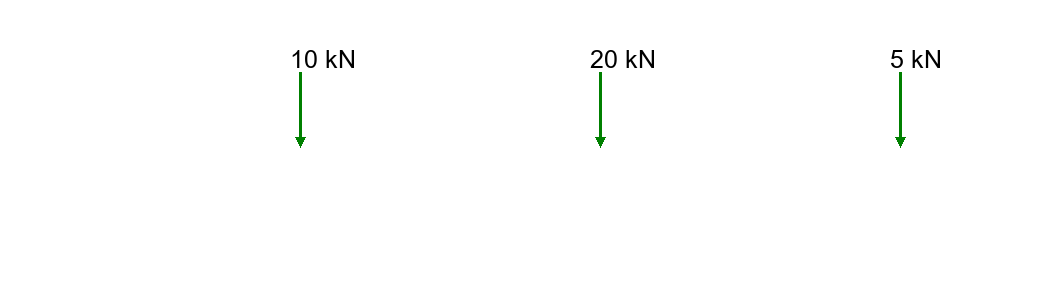

In [51]:
for element in connected_elements:
    for sub_element in element:
        has_frame = isinstance(sub_element, Frame)
        if has_frame:
            image = draw_frame(sub_element, image)
            
        # Similarly, you can check for other classes too if needed
        has_point_load = isinstance(sub_element, PointLoad)
        if has_point_load:
            image = draw_pl(sub_element, image)
        has_fix_support = isinstance(sub_element, FixSupport)
        if has_fix_support:
            # Do something if the sub_element is an instance of FixSupport
            image = draw_fix_support(sub_element, image)
display(image)      

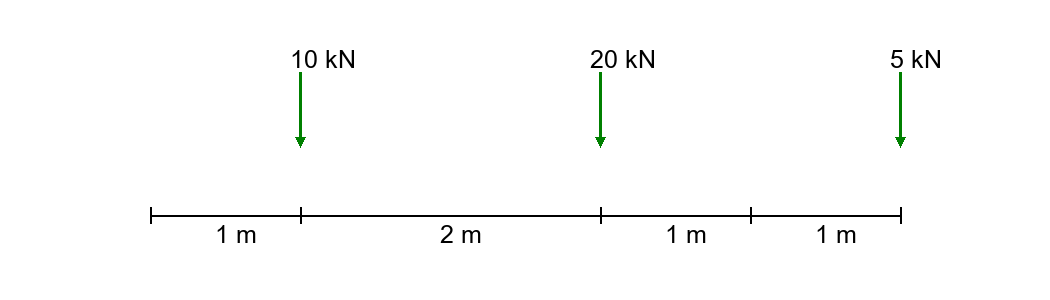

In [52]:
pixel_difference = 65
def draw_dimension(dimensions, img):
    """
    Draws dimensions on a given image based on the provided Dimension instances.
    
    Args:
    - dimensions (list): List of Dimension objects.
    - img (Image): PIL Image object where the dimensions should be drawn.
    
    Returns:
    - Modified Image object with lines drawn and texts added.
    """
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 25)  # Adjust as necessary
    line_color = 'black'

    for dimension in dimensions:
        # Use shape_x of node_1 and node_2 for determining x-coordinates and offset it by extra_pixels_x/2.
        start_x = dimension.node_1.shape_x * node_value_pixels + extra_pixels_x/2
        start_y = extra_pixels_y/2 + pixel_difference
        end_x = dimension.node_2.shape_x * node_value_pixels + extra_pixels_x/2
        end_y = start_y

        # Draw the horizontal line
        draw.line((start_x, start_y, end_x, end_y), fill=line_color, width=2)

        # Draw the vertical lines at the start and end of each horizontal line
        draw.line((start_x, start_y - 8, start_x, start_y + 8), fill=line_color, width=2)
        draw.line((end_x, end_y - 8, end_x, end_y + 8), fill=line_color, width=2)

        # Write the value and unit just below the horizontal line
        text_x = (start_x + end_x) / 2 - 10  # A small offset to center the text
        text_y = end_y + 5  # A small offset to place the text below the line
        draw.text((text_x, text_y), f"{dimension.value} {dimension.unit}", fill=line_color, font=font)

    return img

# Example usage:
image = draw_dimension(spacing_instances, image)
display(image)


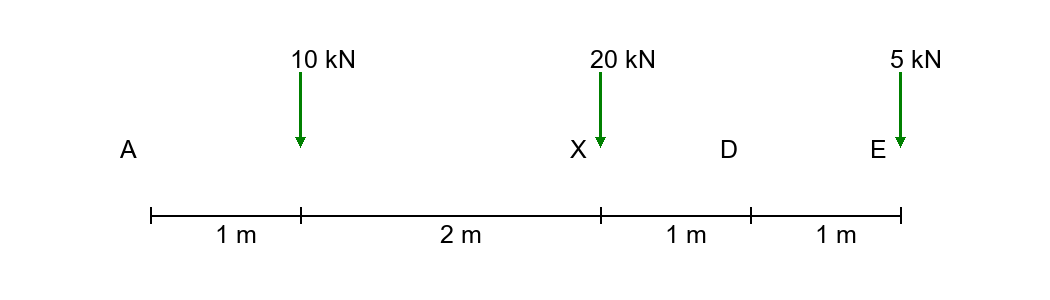

In [53]:
pixel_difference = 15
def label_nodes(node_instances, img):
    """
    Adds labels (node names) to the nodes on the given image.
    
    Args:
    - node_instances (list): List of Node objects.
    - img (Image): PIL Image object where the node names should be written.
    
    Returns:
    - Modified Image object with node names written.
    """
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 25)
    
    for node in node_instances:
        if node.name:  # Only label nodes that have a name
            x = node.shape_x * node_value_pixels + extra_pixels_x/2 - 30
            y = node.shape_y * node_value_pixels + extra_pixels_y/2 - pixel_difference

            draw.text((x, y), node.name, font=font, fill="black")
    
    return img

image = label_nodes(node_instances, image)
display(image)


In [54]:
input_image_path = image_path
output_path = os.path.join(created_image_save_dir_path, "output.pdf")

import os
from PIL import Image, ImageDraw, ImageFont
from PyPDF2 import PdfMerger

def create_pdf_pages(image, image_path, output_path):
    # Function to center text or images
    def calculate_centered_position(draw, text, font, page_width, y_position):
        text_width, text_height = draw.textsize(text, font=font)
        return ((page_width - text_width) / 2, y_position)
    
    # Page setup
    page_width = 595
    page_height = 842
    
    # Create a blank A4 size white background for first page
    pdf_page1 = Image.new('RGB', (page_width, page_height), 'white')
    draw1 = ImageDraw.Draw(pdf_page1)
    
    # Create a blank A4 size white background for second page
    pdf_page2 = Image.new('RGB', (page_width, page_height), 'white')
    draw2 = ImageDraw.Draw(pdf_page2)
    
    # Load fonts
    header_font = ImageFont.truetype("arial.ttf", 24)
    title_font = ImageFont.truetype("arial.ttf", 24)
    
    # Insert "Gönderilen Resim / Input Image" at the top of the first page
    x, y = calculate_centered_position(draw1, "Gönderilen Resim / Input Image", header_font, page_width, 20)
    draw1.text((x, y), "Gönderilen Resim / Input Image", font=header_font, fill="black")
    
    # Load and insert the input image below the header on the first page
    input_img = Image.open(image_path)
    input_img = input_img.resize((495, int(495/input_img.width * input_img.height)))  # maintain aspect ratio
    x, y = (page_width - input_img.width) // 2, y + 50
    pdf_page1.paste(input_img, (x, y))
    
    # Calculate starting y-position for the detected image based on the height of the input image
    detected_img_start_y = y + input_img.height + 30
    
    # Insert "Algılanan Şekil / Detected Shape" below the input image on the first page
    x, y = calculate_centered_position(draw1, "Algılanan Şekil / Detected Shape", title_font, page_width, detected_img_start_y)
    draw1.text((x, y), "Algılanan Şekil / Detected Shape", font=title_font, fill="black")
    
    # Resize the detected image to fit within the PDF and maintain its aspect ratio
    detected_img = image.resize((495, int(495/image.width * image.height)))
    x, y = (page_width - detected_img.width) // 2, y + 40
    pdf_page1.paste(detected_img, (x, y))
    
    # Insert "Çözüm/ Solution" at the top of the second page
    x, y = calculate_centered_position(draw2, "Çözüm/ Solution", header_font, page_width, 20)
    draw2.text((x, y), "Çözüm/ Solution", font=header_font, fill="black")
    
    # Save individual pages as PDF
    temp_output_path_1 = "temp_page1.pdf"
    temp_output_path_2 = "temp_page2.pdf"
    pdf_page1.save(temp_output_path_1, "PDF")
    pdf_page2.save(temp_output_path_2, "PDF")
    
    # Use PyPDF2 to merge the two pages
    merger = PdfMerger()
    with open(temp_output_path_1, 'rb') as file1, open(temp_output_path_2, 'rb') as file2:
        merger.append(file1)
        merger.append(file2)
        with open(output_path, "wb") as output_pdf:
            merger.write(output_pdf)

    # Clean up temporary files
    os.remove(temp_output_path_1)
    os.remove(temp_output_path_2)

# Use the function
create_pdf_pages(image, input_image_path, output_path)
